# Rejection & Importance Sampling in Code

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In Lecture 4 of [Bayesian Data Analysis](https://avehtari.github.io/BDA_course_Aalto) by Aki Vehtari, we covered sampling techniques.
Essentially, we want to infer some properties of a (possibly unnormalized) density function that we can't sample directly from (which we'll call our target distribution $q$).
In this course, $q$ is usually is the product of our likelihood and prior, i.e., the unnormalized posterior.
Rejection sampling and importance sampling are techniques that allow us to transform observations from a proposal distribution (we'll call $g$) from which we can draw samples into observations for our target distribution $q$.

In this notebook, we will look at how to implement these algorithms in practice.
This supplements the course content as well as the [demo](https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch10/demo10_1.ipynb).
Our example objective is to estimate the _variance_ of $q$.
Suppose we _could_ sample from $q$ directly.
Then, given $n$ samples labelled $\theta_1, \theta_2, ..., \theta_n$, we would compute the sample variance $\hat \sigma^2$ as:

$$\hat \mu = \frac{1}{n} \sum_{i=1}^n \theta_i $$
$$\hat \sigma^2 = \frac{1}{n} \sum_{i=1}^n (\theta_i - \hat \mu)^2 $$

For simplicity we're using a _biased_ estimator for the sample variance (to have an unbiased estimator, you'd need to divide by $n-1$).
In code:

In [2]:
def estimate_variance(thetas):
    """Given an array of samples of theta, return the sample variance."""
    mu = np.mean(thetas)
    return np.mean((thetas - mu)**2)

But as mentioned, we don't know how to sample from $q$.

## Set-up

Before getting into the algorithms, we'll set up some functions we need.

First, the (unnormalized) density for $q$. 
We don't care about how the function looks, only that we can evaluate it at various points.
So, we'll use the same function Professor Vehtari provides in his [demo](https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch10/demo10_1.ipynb).

In [3]:
def q_density(theta):
    r = np.array([ 1.1 ,  1.3 , -0.1 , -0.7 ,  0.2 , -0.4 ,  0.06, -1.7 ,
                   1.7 ,  0.3 ,  0.7 ,  1.6 , -2.06, -0.74,  0.2 ,  0.5 ])
    return stats.gaussian_kde(r, bw_method=0.48).evaluate(theta)

Let's plot it in the range $[-3, 3]$ to see how it looks:

[Text(0.5, 0, '$\\theta$'), Text(0, 0.5, '$q(\\theta)$')]

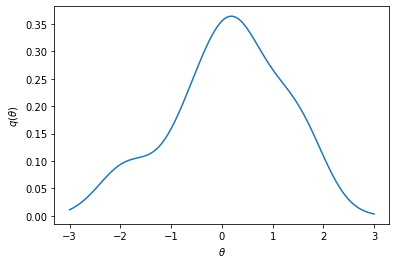

In [4]:
thetas = np.linspace(-3, 3, 100)
fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas))
ax.set(xlabel=r'$\theta$', ylabel=r'$q(\theta)$')

Next, we need to choose our proposal distribution $g$.
In practice, it is tough to choose a good $g$, particularly in higher dimensions, which Professor Vehtari discusses in the lectures.
Since we're working in one dimension, we can visualize our distribution to observe it's roughly bell shaped, and so the normal distribution seems like a reasonable proposal distribution:
We're cheating a little by stealing the distribution from the original demo---in practice this requires some thought and work.

In [5]:
def g_density(theta):
    return stats.norm(0.0, 1.1).pdf(theta)

Plotting $g$ with our $q$:

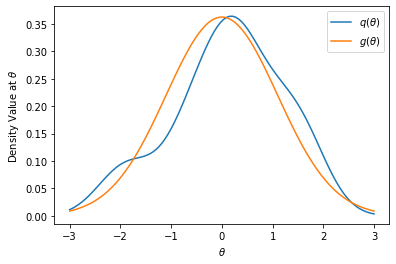

In [6]:
fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas), label=r'$q(\theta)$')
ax.plot(thetas, g_density(thetas), label=r'$g(\theta)$')
ax.set(xlabel=r'$\theta$', ylabel=r'Density Value at $\theta$')
ax.legend()

We also want to be able to sample from $g$:

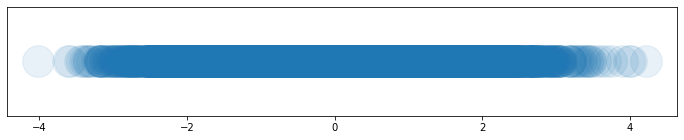

In [7]:
def sample_from_g(n_samples):
    return stats.norm(0.0, 1.1).rvs(n_samples)

g_samples = sample_from_g(10_000)

fig, ax = plt.subplots(figsize=(12, 2))
ax.scatter(g_samples, np.ones_like(g_samples), s=1000, alpha=0.1)
ax.tick_params(axis='y', left=False, labelleft=False)

We have a bunch of values from our sample, which we can see comes from our $g$ distribution in a histogram:

(array([  11.,  147.,  604., 1766., 2833., 2668., 1418.,  450.,   91.,
          12.]),
 array([-4.01874309, -3.1947774 , -2.37081171, -1.54684602, -0.72288034,
         0.10108535,  0.92505104,  1.74901673,  2.57298242,  3.3969481 ,
         4.22091379]),
 <BarContainer object of 10 artists>)

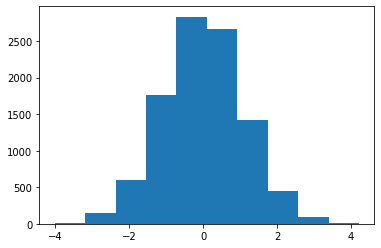

In [8]:
plt.hist(g_samples)

## Rejection Sampling

If we `estimate_variance` directly using `g_samples`, of course we'll get an approximation of the variance of $g$ (which is $1.1^2 = 1.21$)

In [9]:
estimate_variance(g_samples)

1.1957638133717603

If we can transform `g_samples` into samples that follow the $q$ distribution, we could estimate that variance.
As we learned, in rejection sampling, we must first choose an $M$ such that $Mg(\theta) > q(\theta)$ for all $\theta$.
Let's do this visually, since in our one dimensional case, this is easy:

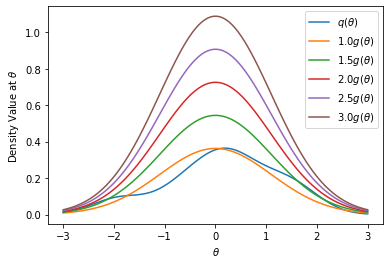

In [10]:
fig, ax = plt.subplots()
ax.plot(thetas, q_density(thetas), label=r'$q(\theta)$')
for M in [1., 1.5, 2.0, 2.5, 3.0]:
    ax.plot(thetas, M*g_density(thetas), label=f'${M}g(\\theta)$')
ax.set(xlabel=r'$\theta$', ylabel=r'Density Value at $\theta$')
ax.legend()

Looks like $M \approx 2.5$ is sufficient.

Recall the plot above gives us the _density_ of our probability distribution, which roughly tells how likely it is to draw a sample from that area.
Since $g$ and $q$ have different densities, we want to essentially resample points that we drew from $g$ to better match $q$, which we do by accepting and rejecting some points.
If the density $q(\theta)$ is large when $g(\theta)$ is large, we should accept more points around that $\theta$.
If the density $q(\theta)$ is small when $g(\theta)$ is large, we should reject more points around that $\theta$.
The ratio $\frac{q(\theta)}{M g(\theta)}$ gives us this information.
We only need $M$ to ensure $Mg(\theta) > q(\theta)$ for all $\theta$, so $0 \le \frac{q(\theta)}{M g(\theta)} \le 1$, so it can be used as a probability of acceptance.
Let's define this function:

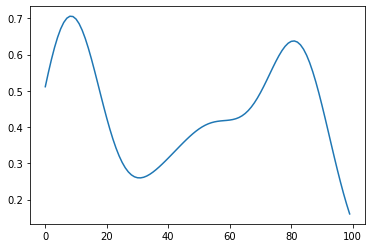

In [11]:
M = 2.5

def acceptance_probability(theta):
    """Returns the acceptance probability at points \theta"""
    return q_density(theta) / (M*g_density(theta))

plt.plot(acceptance_probability(np.linspace(-3, 3, 100)))

We observe we have a pretty good chance of accepting points near the tails, since $q$ has more density in the tails compared to $g$.
Let's look at the acceptance probability of each individual point in our sample:

For example, sample 0.3996897914160634 (in red) has an acceptance probability of 0.416076081793699


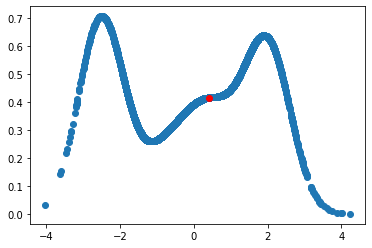

In [22]:
acceptance_probabilities = acceptance_probability(g_samples)
plt.scatter(g_samples, acceptance_probabilities)
plt.scatter(g_samples[5], acceptance_probabilities[5], c='red')
print(f'For example, sample {g_samples[5]} (in red) has an acceptance '
      f'probability of {acceptance_probabilities[5]}')

As expected, this is the same shape as the previous plot since we're showing the same function using our sample.

Now, onto the actual rejection sampling. 
To randomly accept and reject points based on their probability, we'll draw a (uniformly) random number between 0 and 1 for each sample.
If this draw is less than the acceptance probability, we'll keep the point, otherwise, we'll get reject the point:

In [13]:
to_keep = np.random.uniform(size=len(g_samples)) < acceptance_probabilities
to_keep

array([False,  True, False, ..., False,  True,  True])

The array is `True` for the indices we'll keep, `False` for the ones we reject.
We'll use _boolean masking_ to grab the points we're keeping from our `g_samples` array:

In [14]:
q_samples = g_samples[to_keep]
print(f'Original number of samples: {len(g_samples)}')
print(f'Number of accepted samples: {len(q_samples)}')

Original number of samples: 10000
Number of accepted samples: 3972


We can see that in our case, rejection sampling was pretty inefficient--we threw away a whole bunch of points.
Our *effective sample size* was only 3958, which we can improve slightly by using a smaller $M$ (while still keeping our inequality).
But now, we can use those samples to get the variance of $q$:

In [15]:
estimate_variance(q_samples)

1.3394609389083383

## Importance Sampling

It can be challenging to find a $g$ and $M$ such that $Mg(\theta) > q(\theta)$ for all $\theta$.
Even when we do, it's often pretty innefficient because $Mg(\theta)$ will be quite different from $q(\theta)$ so we'll end up rejecting a lot of points.

Importance sampling improves this with one key observation: often, the property of interest is an expectation.
If we have samples from $q$, we could just average those samples (for the variance, we averaged a function of those samples).
If we have samples from $g$, we can do a _weighted average_ where we downweight points that would been less likely to be sampled from $q$ vs. $g$, and upweight points that would be more likely to be samples from $q$ vs. $g$.

We assign these weights using the ratio $\frac{q(\theta)}{g(\theta)}$:effective sample size

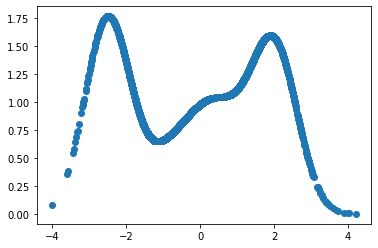

In [16]:
weights = q_density(g_samples)/g_density(g_samples)

plt.scatter(g_samples, weights)

As we can see, the weights are just a scaled version of our rejection probabilities!
We can use these weights along with `g_samples` to compute the variance of $q$ by using a weighted mean instead of a normal mean:

In [17]:
def estimate_variance2(thetas, weights):
    """Given an array of samples of theta with weights, return the sample variance."""
    normalizing_val = np.sum(weights)
    mu = np.sum(weights*thetas) / normalizing_val
    # Below, we are doing E[(\theta-\mu)^2]. We want to weight each item in the expectation, not each sample.
    return np.sum(weights*(thetas - mu)**2) / normalizing_val

Notice this function with a weights of all 1s is the same as our original `estimate_variance`.
To check that, let's re-compute the variance of $g$ from the sample:

In [18]:
estimate_variance2(g_samples, np.ones_like(g_samples))

1.1957638133717603

Now, let's compute the variance of our $q$ using these importance weights:

In [19]:
estimate_variance2(g_samples, weights)

1.3348793523483617

Nice, we get about the same answer!
We can compute the _effective sample size_ using the formula:

$$\tilde w_i = \frac{w_i}{\sum_{i=1}^n w_i} \quad \forall 1 \le i \le n$$
$$n_{ESS} = \frac{1}{\sum_{i=1}^n \tilde w_i^2} $$

In [20]:
normalized_weights = weights / np.sum(weights)
n_ess = 1.0 / np.sum(normalized_weights**2)
n_ess

9385.454076320735

Our effective sample size is much better than with rejection sampling, since $g$ was pretty similar to $q$ everywhere.